## POOL mBABA_UST

Modification2 (Add dsw_oracle fallback_window_size=48h)
### Comparison simulation - volatility mitigator disabled/enabled

*VM parameters (custom):* 
- WINDOW_SIZE = 24h
- FALLBACK_WINDOW_SIZE = 48h
- PERIOD_SIZE = 1h
- PRICE_TOLLERANCE_TRESHOLD = 98

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 1000)

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [3]:
EXPERIMENT_ID = 76

X_NAME = 'mBABA'
Y_NAME = 'UST'

WINDOW_SIZE = 24 * 60 * 60

In [4]:
BASE_DIR = fr'..\..\..\data\real_transactions\experiment_{EXPERIMENT_ID}'

In [5]:
os.listdir(BASE_DIR)

['0', '1', 'config.txt']

In [6]:
def read_simulation(sim_id: int):
    pool_state_before_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_before_transaction_normalized.csv'
    pool_state_after_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_after_transaction_normalized.csv'
    swap_transactions_path = fr'{BASE_DIR}\\{sim_id}\swaps_normalized.csv'
    mint_transactions_path = fr'{BASE_DIR}\\{sim_id}\mints_normalized.csv'
    burn_transactions_path = fr'{BASE_DIR}\\{sim_id}\burns_normalized.csv'
    
    # read swaps
    pool0_df = pd.read_csv(pool_state_before_transactions_path)
    pool1_df = pd.read_csv(pool_state_after_transactions_path)
    swaps_df = pd.read_csv(swap_transactions_path)
    
    pool0_df.columns = pool0_df.columns.map(lambda x : x + '_before' if x != 'transaction_id' else x)

    swaps_df = pd.merge(swaps_df, pool0_df, left_on='id', right_on='transaction_id')
    swaps_df = pd.merge(swaps_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    swaps_df['transaction_timestamp'] = pd.to_datetime(swaps_df.transaction_timestamp, unit='s')
    swaps_df['block_timestamp'] = pd.to_datetime(swaps_df.block_timestamp, unit='s')
    
    swaps_df.loc[:, 'X_price'] = swaps_df['reserve_Y'] / swaps_df['reserve_X']
    
    # price impact of swap / 100%
    swaps_df.loc[:, 'price_diff'] = (swaps_df['reserve_Y'] / swaps_df['reserve_X'] - swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before']) / (swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before'])
    
    # read mints
    mints_df = pd.read_csv(mint_transactions_path)
    mints_df = pd.merge(mints_df, pool0_df, left_on='id', right_on='transaction_id')
    mints_df = pd.merge(mints_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    # read burns
    burns_df = pd.read_csv(burn_transactions_path)
    burns_df = pd.merge(burns_df, pool0_df, left_on='id', right_on='transaction_id')
    burns_df = pd.merge(burns_df, pool1_df, left_on='transaction_id', right_on='transaction_id') 
    
    return swaps_df, mints_df, burns_df

In [7]:
swaps0_df, mints0_df, burns0_df = read_simulation(0) # without vm
swaps1_df, mints1_df, burns1_df = read_simulation(1) # with vm

In [8]:
swaps0_df.head()

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
0,1,UST,mBABA,950.000000,0.0,3.517667,3.800000,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,571,2020-12-03 19:03:30,2020-12-03 19:03:22,0xea779b667c8dde199c3abe49b1c732c009276bfb1643...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x443b29e221b54f7be8c0805859f57028cff0a1ca,1,1167.962326,311331.417600,3.636234e+08,0,0,False,1164.444659,312277.617600,3.636300e+08,0,0,False,268.177294,0.006069
1,3,UST,mBABA,1400.000000,0.0,5.145454,5.600000,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,633,2020-12-03 19:19:00,2020-12-03 19:18:51,0xeefa261f3ca7743fd27ed017e1546cb4d7061f9aec06...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xcc05590ba009b10cb30a7b7e87e2f517ea2f4301,3,1167.987123,313227.657744,3.658459e+08,0,0,False,1162.841669,314622.057744,3.658556e+08,249404,3,False,270.563109,0.008896
2,4,mBABA,UST,5.181502,0.0,1381.808478,5.527234,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,646,2020-12-03 19:22:15,2020-12-03 19:22:03,0xabd1c1da10b4e202e352b92fe858a26f2cc750ca1b08...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xcc05590ba009b10cb30a7b7e87e2f517ea2f4301,4,1162.841669,314622.057744,3.658556e+08,249404,3,False,1168.023171,313234.722031,3.658654e+08,302164,4,False,268.175093,-0.008826
3,5,UST,mBABA,208.000000,0.0,0.767352,0.832000,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,744,2020-12-03 19:46:45,2020-12-03 19:46:39,0x0bd039d09278d3908f5ceecd06afed1ba1e5fadb9166...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x443b29e221b54f7be8c0805859f57028cff0a1ca,5,1168.023171,313234.722031,3.658654e+08,302164,4,False,1167.255819,313441.890031,3.658669e+08,696382,9,False,268.528873,0.001319
4,6,UST,mBABA,2468.188484,0.0,9.029215,9.872754,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,748,2020-12-03 19:47:45,2020-12-03 19:47:40,0x1864dddfe597d746b3045dfff96a1db0870eb267c62f...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xd1373dfb5ff412291c06e5dfe6b25be239dbcf3e,6,1167.255819,313441.890031,3.658669e+08,696382,9,False,1158.226603,315900.205761,3.658840e+08,712493,9,False,272.744733,0.015700


In [9]:
swaps0_df.status.value_counts()

SUCCESS    1830
Name: status, dtype: int64

In [10]:
swaps1_df.status.value_counts()

SUCCESS    1830
Name: status, dtype: int64

In [11]:
ratio_blocked_volatility = swaps1_df[swaps1_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION'].shape[0]/swaps1_df.shape[0] 

print(f"Blocked by volatility mitigator ratio: {ratio_blocked_volatility}")

Blocked by volatility mitigator ratio: 0.0


In [12]:
swaps1_df.mitigator_check_status.value_counts()

CHECKED                1818
CANT_CONSULT_ORACLE      12
Name: mitigator_check_status, dtype: int64

In [13]:
ratio_twap_not_available = swaps1_df[swaps1_df.mitigator_check_status == 'CANT_CONSULT_ORACLE'].shape[0]/swaps1_df.shape[0] 

print(f"TWAP not available ratio: {ratio_twap_not_available}")

TWAP not available ratio: 0.006557377049180328


In [14]:
# Check if all burns were completed successfully

print("Burns status without volatility mitigation mechanism")
print(burns0_df.status.value_counts())

print("\nBurns status with volatility mitigation mechanism")
print(burns0_df.status.value_counts())

Burns status without volatility mitigation mechanism
SUCCESS    143
Name: status, dtype: int64

Burns status with volatility mitigation mechanism
SUCCESS    143
Name: status, dtype: int64


Text(0.5, 1.0, 'Swaps slice_factor/out_amount_diff scatterplot (split by status)')

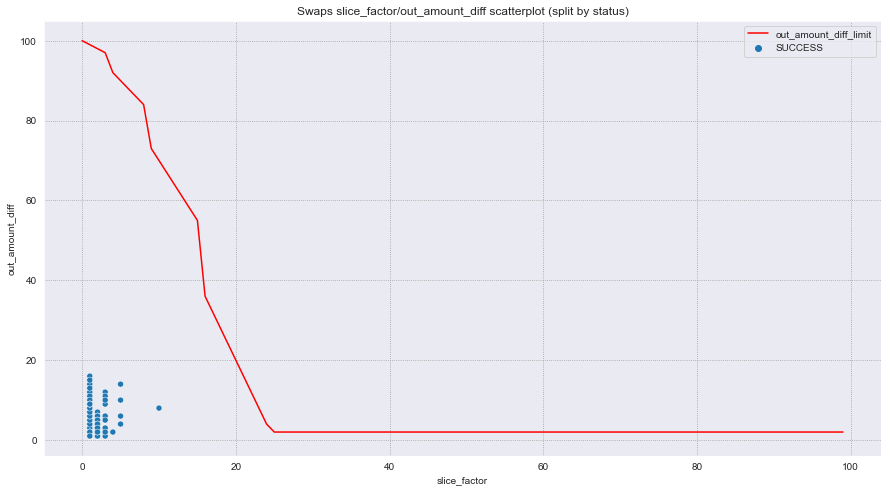

In [14]:
from scipy import stats

fig, ax = plt.subplots(figsize=(15, 8))
    
sns.scatterplot(data=swaps1_df[swaps1_df.mitigator_check_status == 'CHECKED'], x='slice_factor', y='out_amount_diff', hue='status')

slice_factor = np.arange(0, 100)
slice_factor_curve = slice_factor * np.sqrt(slice_factor).astype(int)
slice_factor_curve[slice_factor_curve > 98] = 98
out_amount_diff = (100 - slice_factor_curve)
sns.lineplot(x=slice_factor, y=out_amount_diff, color='red', label='out_amount_diff_limit')
ax.set_title('Swaps slice_factor/out_amount_diff scatterplot (split by status)')

The out_amount_diff_limit border is not smooth, because the slice_factor_curve is computed according to the formula slice_factor * sqrt(slice_factor), where the sqrt(slice_factor) is rounded down in the original contract

**It can be seen that there are more observations than in the initial version, as the volatility mitigation checked much more transactions because of the TWAP availability.**

In [25]:
swaps0_df

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
0,1,UST,mBABA,950.000000,0.0,3.517667,3.800000,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,571,2020-12-03 19:03:30,2020-12-03 19:03:22,0xea779b667c8dde199c3abe49b1c732c009276bfb1643...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x443b29e221b54f7be8c0805859f57028cff0a1ca,1,1167.962326,3.113314e+05,3.636234e+08,0,0,False,1164.444659,3.122776e+05,3.636300e+08,0,0,False,268.177294,0.006069
1,3,UST,mBABA,1400.000000,0.0,5.145454,5.600000,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,633,2020-12-03 19:19:00,2020-12-03 19:18:51,0xeefa261f3ca7743fd27ed017e1546cb4d7061f9aec06...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xcc05590ba009b10cb30a7b7e87e2f517ea2f4301,3,1167.987123,3.132277e+05,3.658459e+08,0,0,False,1162.841669,3.146221e+05,3.658556e+08,249404,3,False,270.563109,0.008896
2,4,mBABA,UST,5.181502,0.0,1381.808478,5.527234,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,646,2020-12-03 19:22:15,2020-12-03 19:22:03,0xabd1c1da10b4e202e352b92fe858a26f2cc750ca1b08...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xcc05590ba009b10cb30a7b7e87e2f517ea2f4301,4,1162.841669,3.146221e+05,3.658556e+08,249404,3,False,1168.023171,3.132347e+05,3.658654e+08,302164,4,False,268.175093,-0.008826
3,5,UST,mBABA,208.000000,0.0,0.767352,0.832000,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,744,2020-12-03 19:46:45,2020-12-03 19:46:39,0x0bd039d09278d3908f5ceecd06afed1ba1e5fadb9166...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x443b29e221b54f7be8c0805859f57028cff0a1ca,5,1168.023171,3.132347e+05,3.658654e+08,302164,4,False,1167.255819,3.134419e+05,3.658669e+08,696382,9,False,268.528873,0.001319
4,6,UST,mBABA,2468.188484,0.0,9.029215,9.872754,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,748,2020-12-03 19:47:45,2020-12-03 19:47:40,0x1864dddfe597d746b3045dfff96a1db0870eb267c62f...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xd1373dfb5ff412291c06e5dfe6b25be239dbcf3e,6,1167.255819,3.134419e+05,3.658669e+08,696382,9,False,1158.226603,3.159002e+05,3.658840e+08,712493,9,False,272.744733,0.015700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1825,2269,mBABA,UST,300.913685,0.0,45014.816024,180.059264,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,2030754,2021-11-21 06:09:15,2021-11-21 06:09:13,0x41568627dc56d5a79aebeec7f28426c874f2c12610ba...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x9fb7e5f71517c9b0059e3200b51bbd1477db333b,2269,37876.455325,5.768330e+06,2.184839e+11,6585589937,144637,False,38177.369010,5.723135e+06,2.184942e+11,6595134158,145048,False,149.909106,-0.015655
1826,2270,mBABA,UST,201.689323,0.0,29776.978190,119.107913,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,2038468,2021-11-22 14:17:45,2021-11-22 14:17:37,0xc06f4c17739ab535b9459976804df5c27a49af7446b6...,0x1111111254fb6c44bac0bed2854e76f90643097d,0x28645d690057b73ac8511ed34d2921992a8085ee,2270,38177.369010,5.723135e+06,2.184942e+11,6595134158,145048,False,38379.058333,5.693239e+06,2.185012e+11,6612480140,145820,False,148.342337,-0.010451
1827,2271,mBABA,UST,204.294479,0.0,29845.185770,119.380743,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,2039853,2021-11-22 20:04:00,2021-11-22 20:03:52,0x7ea19392bed665134439ab5f274420a232b021d85e2a...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x2c691e3c7c05ebd156e40684ee299f2de62a9fd7,2271,38379.058333,5.693239e+06,2.185012e+11,6612480140,145820,False,38583.352812,5.663275e+06,2.185081e+11,6615561952,145960,False,146.780262,-0.010530
1828,2272,mBABA,UST,294.508337,0.0,42474.761150,169.899045,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,2042491,202

Text(0, 0.5, 'Count')

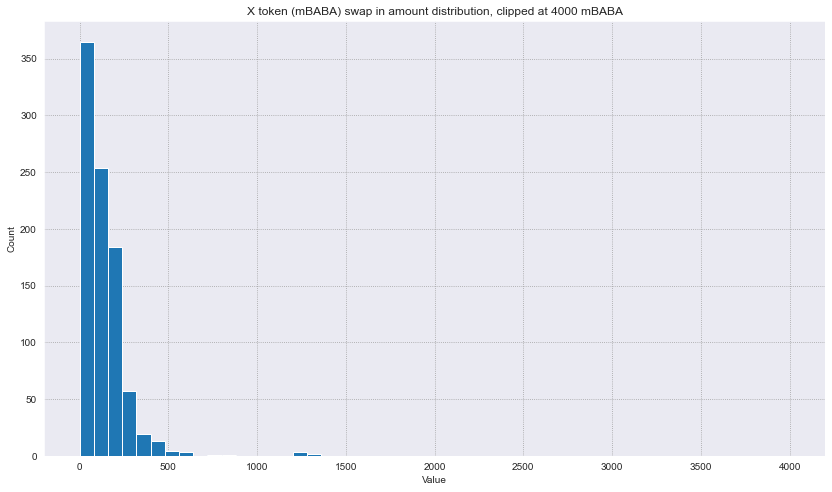

In [26]:
UPPER_LIMIT = 4000

fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == X_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"X token ({X_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {X_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

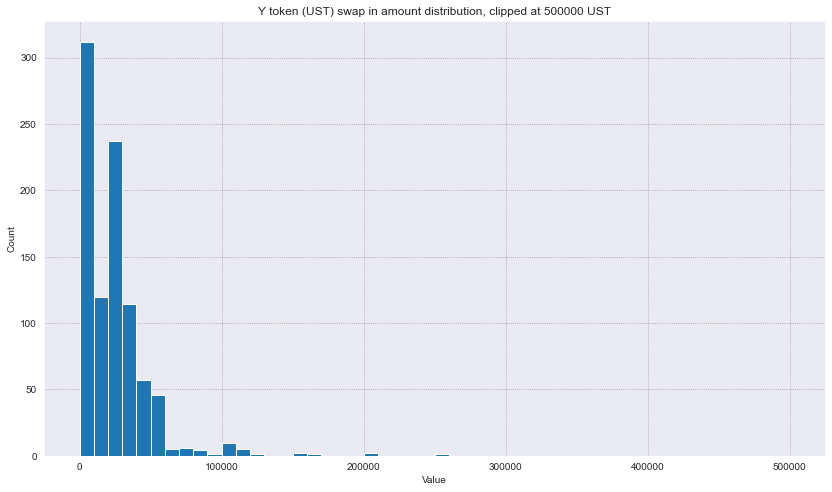

In [27]:
UPPER_LIMIT = 500000

fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {Y_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

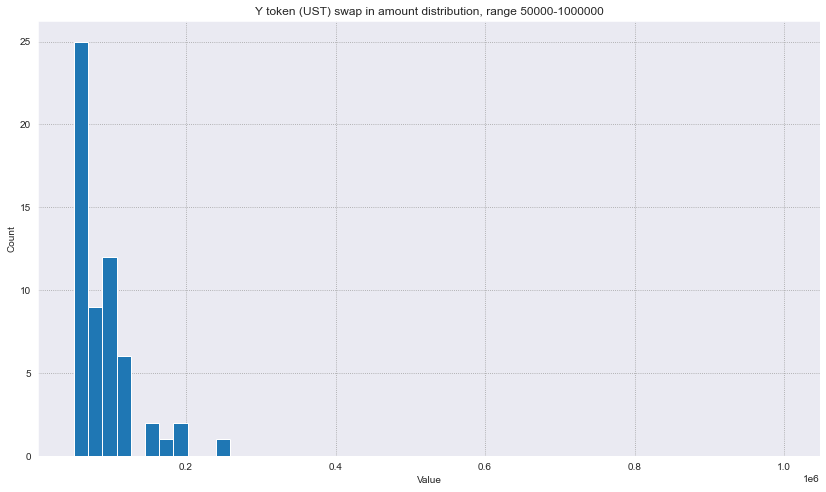

In [28]:
LOWER_LIMIT = 50000
UPPER_LIMIT = 1000000
fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT
amounts = amounts[amounts > LOWER_LIMIT]
ax = amounts.hist(range=(LOWER_LIMIT, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, range {LOWER_LIMIT}-{UPPER_LIMIT}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

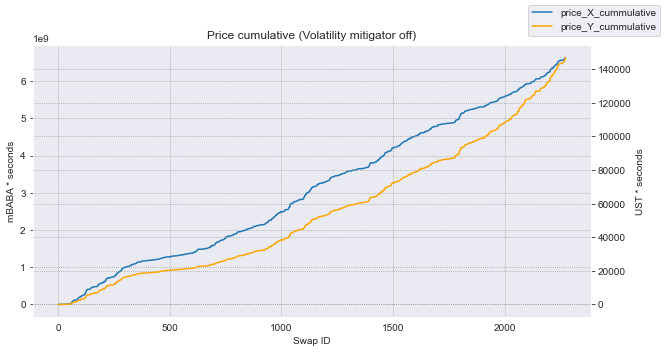

In [29]:

fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.id, swaps0_df.price_X_cumulative,  label='price_X_cummulative')
ax2.plot(swaps0_df.id, swaps0_df.price_Y_cumulative,  label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator off)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

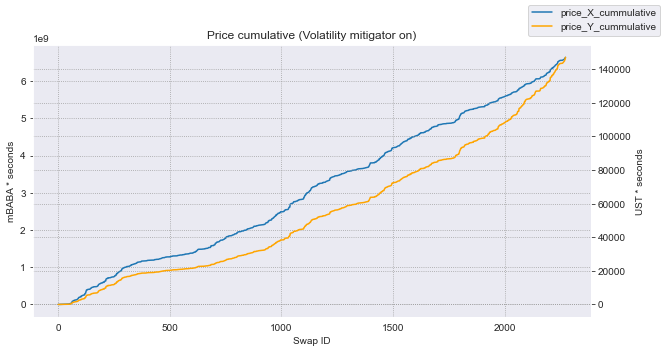

In [30]:

fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.id, swaps1_df.price_X_cumulative,  label='price_X_cummulative')
ax2.plot(swaps1_df.id, swaps1_df.price_Y_cumulative,  label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator on)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

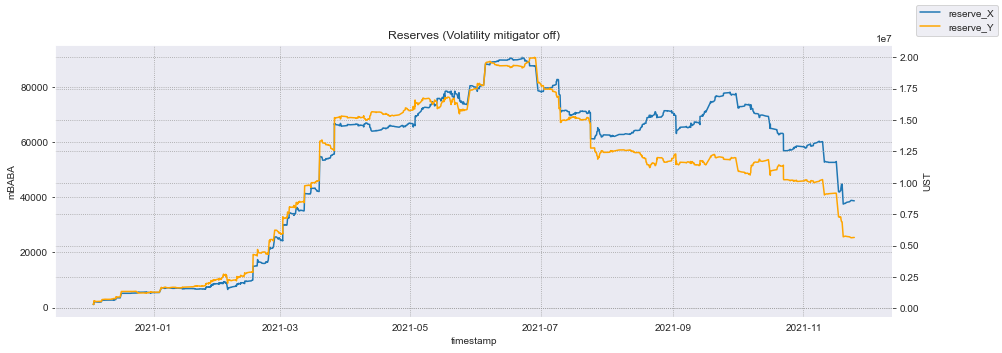

In [31]:
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.transaction_timestamp, swaps0_df.reserve_X, label='reserve_X')
ax2.plot(swaps0_df.transaction_timestamp, swaps0_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator off)')

fig.legend()

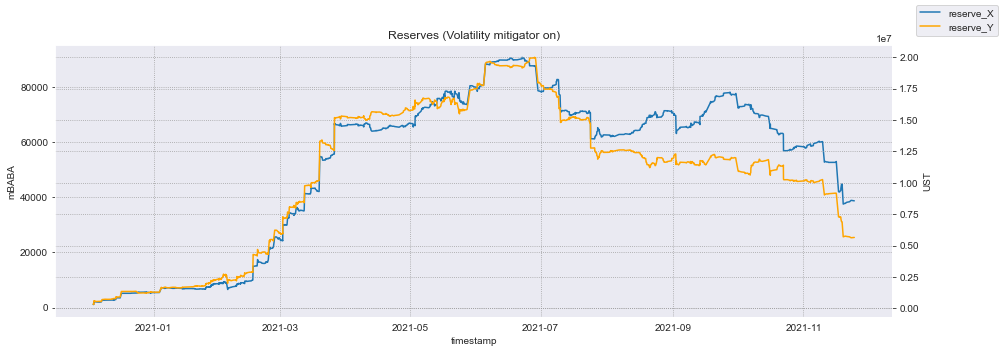

In [32]:
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_X, label='reserve_X')
ax2.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator on)')

fig.legend()

**The variation of reserves over time is very similar at the first glance with and without the volatility mitigator**

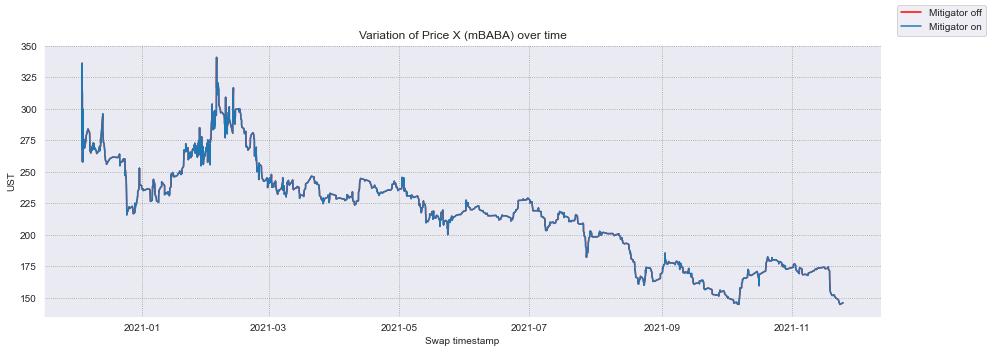

In [33]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=swaps0_df['transaction_timestamp'], y=swaps0_df['X_price'], linestyle='solid', marker=None, label='Mitigator off', color='red')
ax.plot_date(x=swaps1_df['transaction_timestamp'], y=swaps1_df['X_price'], linestyle='solid', marker=None, label='Mitigator on',)

ax.set_title(f'Variation of Price X ({X_NAME}) over time')
#ax.set_ylim(0, 0.1)
ax.set_xlabel('Swap timestamp')
ax.set_ylabel(Y_NAME)
fig.legend()

**The variation of price is the same as in the initial version**

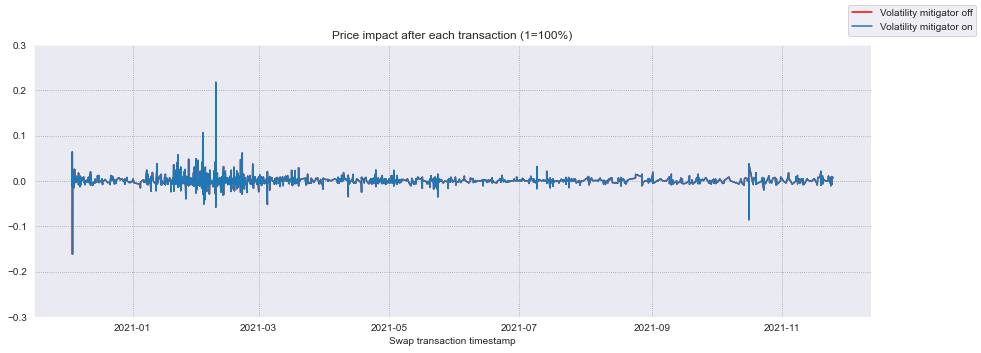

In [165]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(data=swaps0_df, x='transaction_timestamp', y='price_diff', linestyle='solid', color='red', marker=None, label='Volatility mitigator off')
ax.plot_date(data=swaps1_df, x='transaction_timestamp', y='price_diff', linestyle='solid', marker=None, label='Volatility mitigator on')

ax.set_ylim(-0.3, 0.3)
ax.set_xlabel('Swap transaction timestamp')
ax.set_title('Price impact after each transaction (1=100%)')
fig.legend()

**The price impact after each transaction doesn't exceed 0.25 and is the same as initially**

In [125]:
swaps1_df.iloc[725:750]

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
725,966,UST,mAAPL,313490.743725,0.0,1913.341160,1253.962975,CHECKED,2078.476324,8.0,11.0,33.0,SUCCESS,387653,2021-02-08 22:52:32,2021-02-08 22:52:22,0x7e262e31704c6c8b638fe545594ddfd7acd95ffbf2b0...,966,20457.340891,3.007952e+06,6.153470e+10,780816423,43351,True,18543.999731,3.320189e+06,6.156958e+10,780820834,43351,True,179.043837,0.217693
726,968,mAAPL,UST,251.381561,0.0,44042.391614,176.169566,CHECKED,37927.774708,14.0,2.0,2.0,SUCCESS,387655,2021-02-08 22:53:02,2021-02-08 22:52:53,0x9c25fdc9ad84bcef3527d31503aa90c89aec804f773a...,968,20462.871786,3.665379e+06,7.500418e+10,780820834,43351,True,20714.253347,3.621160e+06,7.500963e+10,780826207,43351,True,174.814903,-0.024053
727,969,mAAPL,UST,61.940243,0.0,10688.156395,42.752626,CHECKED,9346.195307,13.0,1.0,1.0,SUCCESS,387661,2021-02-08 22:54:32,2021-02-08 22:54:18,0x19e9d0ab55b282ade13aa05b1e5409a2131a4f8b6bb6...,969,20714.253347,3.621160e+06,7.500963e+10,780826207,43351,True,20776.193590,3.610429e+06,7.501098e+10,780841941,43352,True,173.777225,-0.005936
728,970,mAAPL,UST,257.410694,0.0,43748.188540,174.992754,CHECKED,38840.832772,11.0,2.0,2.0,SUCCESS,387661,2021-02-08 22:54:32,2021-02-08 22:54:18,0x29d894eb37a6220a854ee2a26d0b68327bef72b34a42...,970,20776.193590,3.610429e+06,7.501098e+10,780841941,43352,True,21033.604284,3.566506e+06,7.501648e+10,780841941,43352,True,169.562289,-0.024255
729,971,mAAPL,UST,641.926100,0.0,104597.692025,418.390768,CHECKED,96862.764578,7.0,4.0,8.0,SUCCESS,387663,2021-02-08 22:55:02,2021-02-08 22:54:58,0xe8e506485374eb3d5324346704e27034f92168c9c0cf...,971,21033.604284,3.566506e+06,7.501648e+10,780841941,43352,True,21675.530384,3.461490e+06,7.502963e+10,780847028,43352,True,159.695747,-0.058188
730,972,mAAPL,UST,327.569478,0.0,51024.939180,204.099757,CHECKED,49428.517278,3.0,2.0,2.0,SUCCESS,387664,2021-02-08 22:55:17,2021-02-08 22:55:10,0xc506a51a6f701ff5860f81255471b67138510158b8fc...,972,21675.530384,3.461490e+06,7.502963e+10,780847028,43352,True,22003.099862,3.410261e+06,7.503631e+10,780849423,43352,True,154.990024,-0.029467
731,973,mAAPL,UST,336.190574,0.0,50816.450950,203.265804,CHECKED,50729.774967,NaN,NaN,NaN,SUCCESS,387667,2021-02-08 22:56:02,2021-02-08 22:55:57,0x2954589a88559944ca9ee734993f3ffbc32a863289bc...,973,22003.099862,3.410261e+06,7.503631e+10,780849423,43352,True,22339.290436,3.359241e+06,7.504307e+10,780856398,43352,True,150.373677,-0.029785
732,974,mAAPL,UST,66.659662,0.0,9894.390649,39.577563,CHECKED,10058.659253,1.0,1.0,1.0,SUCCESS,387670,2021-02-08 22:56:47,2021-02-08 22:56:35,0x3c227703596b09e360ad17457b5c13f5d9e13053a831...,974,22339.290436,3.359241e+06,7.504307e+10,780856398,43352,True,22405.950098,3.349307e+06,7.504441e+10,780863164,43353,True,149.482940,-0.005923
733,975,mAAPL,UST,68.924194,0.0,10168.992621,40.675970,CHECKED,10400.269204,2.0,1.0,1.0,SUCCESS,387681,2021-02-08 22:59:32,2021-02-08 22:59:32,0xd6d271f001b476b4e004bce7fb3a06514db9f84be74f...,975,22405.950098,3.349307e+06,7.504441e+10,780863164,43353,True,22474.874292,3.339098e+06,7.504580e+10,780887829,43354,True,148.570247,-0.006106
734,976,mAAPL,UST,103.565029,0.0,15163.639226,60.654557,CHECKED,15627.286044,3.0,1.0,1.0,SUCCESS,387685,2021-02-08 23:00:32,2021-02-08 23:00:21,0x8e8f63e463cda0b38a57ffa91391f987d9cdc9100a36...,976,22474.874292,3.339098e+06,7.504580e+10,780887829,43354,True,22578.439321,3.323873e+06,7.504787e+10,780896743,43354,True,147.214485,-0.009125


In [123]:
swaps1_df[swaps1_df.price_diff > 0.4]

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
